<a href="https://colab.research.google.com/github/DriftKing-byte/QA-Chatbot/blob/main/Computer_Vision_Image_Classification_(Non_Transformer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There's three categories in computer vision: image classification, object detection, and image segmentation. This project will focus on image classification. The transformers model architecture is the best model and the transformer architecture is not a CNN. To compete with this architecture, the best CNN developed is known as ConvNeXT. The best CNN info can found at [keras apps](https://keras.io/api/applications/). This specific project will focus on using the ResNet architecture. The ResNet arch is pre-trained so no need to modify the kernel size or stride or padding. All of it is hard-coded. Only image input must match the input requirement for the model. ResNet is flexible, so the acceptable input can be changed to size of the image. This makes things much easier. Resources: Krish Naik has pytorch transfer learning [episode](https://www.udemy.com/course/complete-computer-vision-bootcamp-with-pytoch-tensorflow/learn/lecture/49092885#overview), but there is a keras one on [YT](https://www.youtube.com/watch?v=JcU72smpLJk). I just changed the model to ConvNeXT and changed the image dataset to lung images [link text](https://data.mendeley.com/datasets/rscbjbr9sj/2).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.python.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Purpose: To identify pneumonia or normal lung based on lugn scan. It is a binary classification but softmax was used and is ok to use for 2 more classes. ConvNeXT Tiny was leveraged on GPU. Using CPU would take 2hrs+! This was shortened to less than 5 minutes. The result was an accuracy of above 99% (near 100% accuracy).

# Load Data

Google Drive upload below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
data_dir = Path("/content/drive")
print(data_dir.exists())

True


Local drive upload below.

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving ChestXRay2017.zip to ChestXRay2017.zip


Extract for Google Drivel; don't need to do it twice.

In [ ]:
!unzip "/content/drive/My Drive/Datasets/ChestXRay2017.zip" -d 'ChestXRay2017_extracted'

Streaming output truncated to the last 5000 lines.
  inflating: ChestXRay2017_extracted/chest_xray/train/PNEUMONIA/person1562_bacteria_4078.jpeg  
  inflating: ChestXRay2017_extracted/chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: ChestXRay2017_extracted/chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: ChestXRay2017_extracted/chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: ChestXRay2017_extracted/chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: ChestXRay2017_extracted/chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: ChestXRay2017_extracted/chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: ChestXRay2017_extracted/chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: ChestXRay2017_extracted/chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: ChestXRay2017_extracted/chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inf

Extract for manual

In [ ]:
!unzip 'ChestXRay2017.zip' -d 'ChestXRay2017_extracted'

In [ ]:
from pathlib import Path

data_dir = Path("ChestXRay2017_extracted")
print(data_dir.exists())  # Should be True

# Show subfolders/files
for item in data_dir.iterdir():
    print(item)


True
ChestXRay2017_extracted/__MACOSX
ChestXRay2017_extracted/chest_xray


In [ ]:
data_dir = Path("ChestXRay2017_extracted/chest_xray")
print(data_dir.exists())
print(list(data_dir.iterdir()))

True
[PosixPath('ChestXRay2017_extracted/chest_xray/test'), PosixPath('ChestXRay2017_extracted/chest_xray/train'), PosixPath('ChestXRay2017_extracted/chest_xray/.DS_Store')]


ChestXRay2017_extracted/chest_xray/train/NORMAL/NORMAL2-IM-1142-0001.jpeg


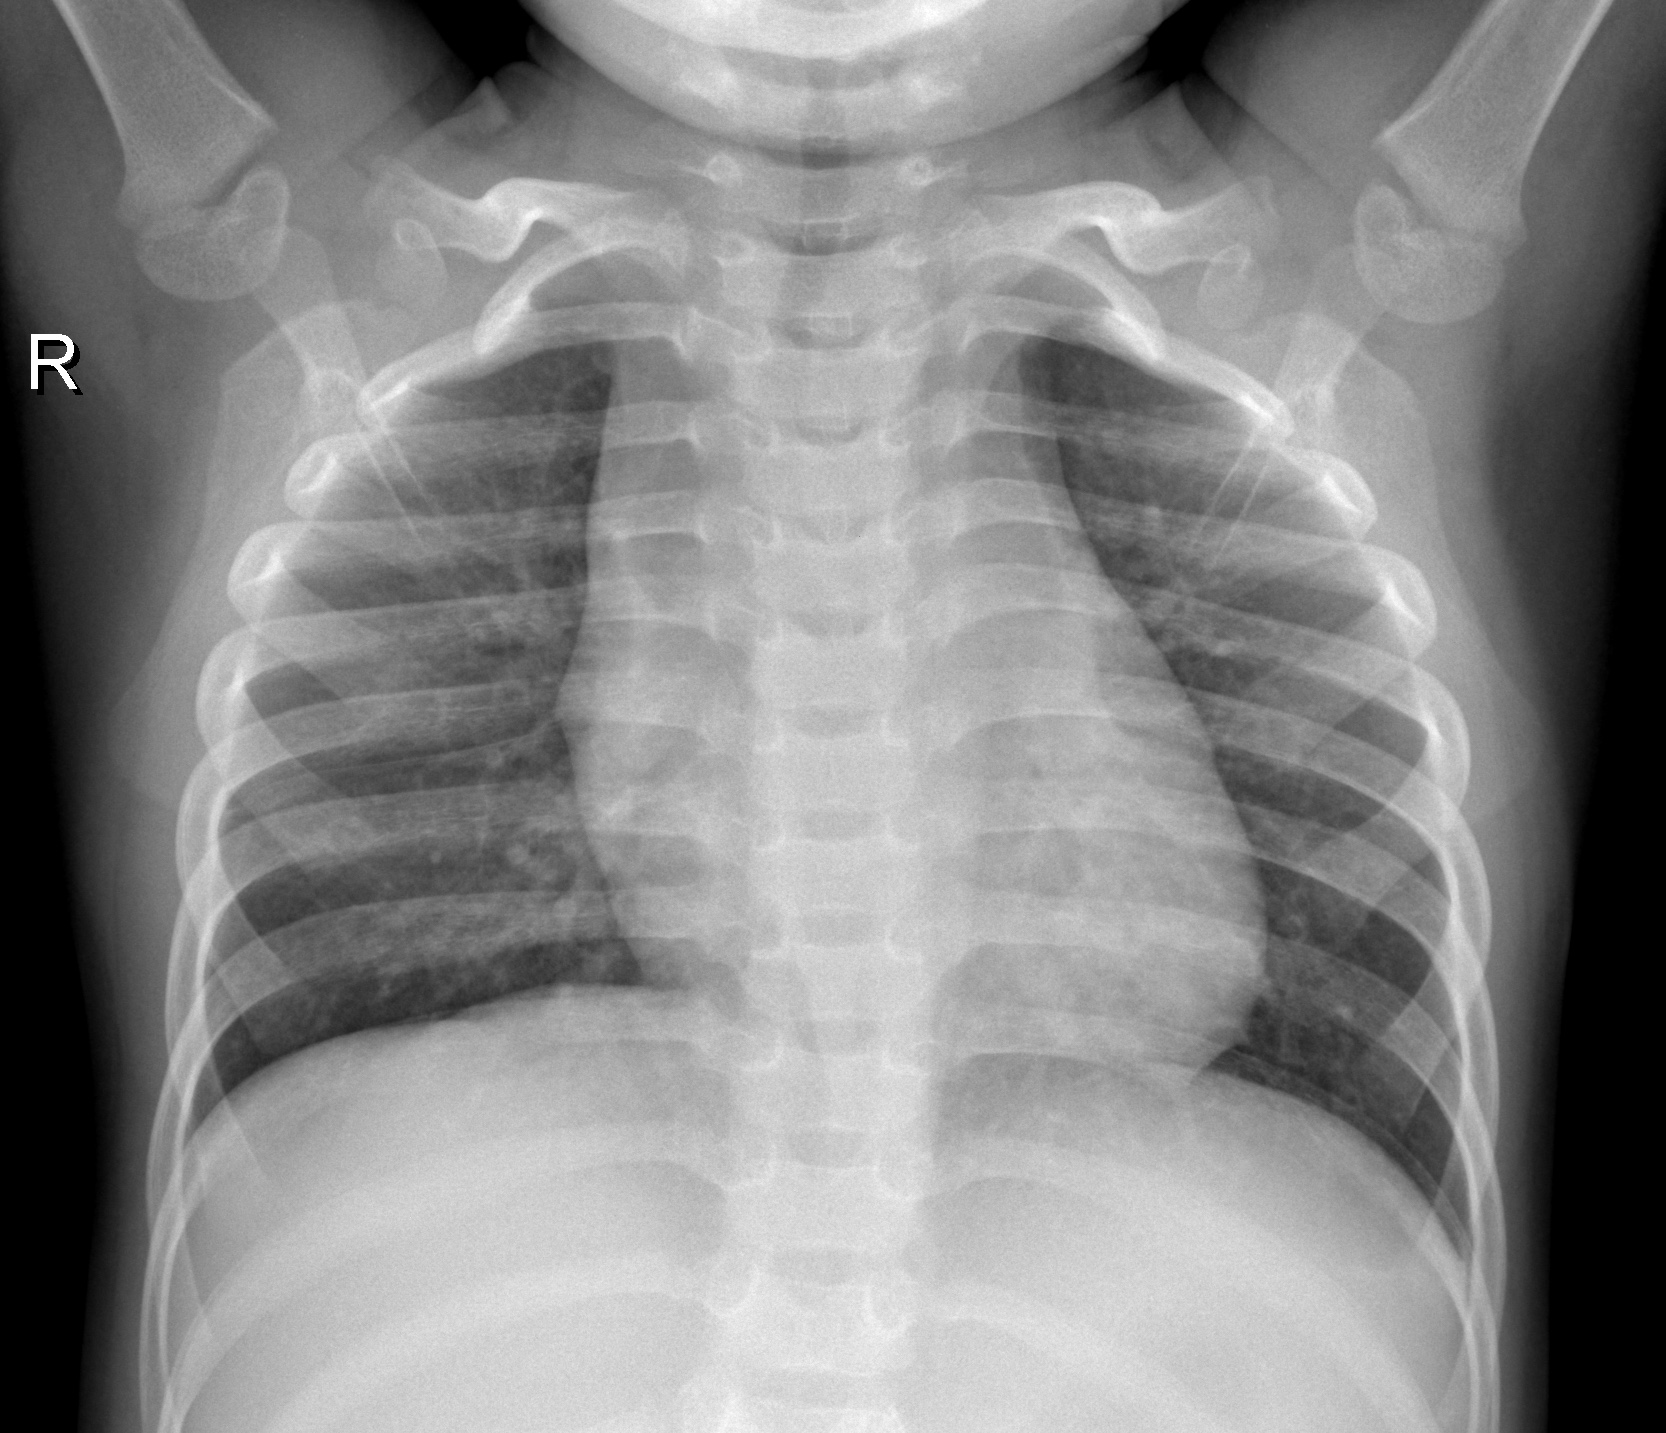

In [ ]:
normal_lung_images = list(data_dir.glob('train/NORMAL/*'))
print(normal_lung_images[0])
PIL.Image.open(str(normal_lung_images[0]))

For images with labels they should be properly organized into subfolders within train and test. If they were all mixed, labeling should be done and mapped with the images or other forms of training like unsupervision should be done. Either way that is time-intensive and labeled images are always best to have to identify even in unsupervised what the image is.  

The directory method filters the train folder categorically so normal will be 0 and pneumonia will be 1. Then within these folders, it will take 80% for training and put in keras's training subset.

In [ ]:
train_dir = data_dir / "train"
img_height, img_width = 224, 224
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    label_mode = "categorical",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode = "grayscale"
)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    label_mode = "categorical",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode = "grayscale"
)

Found 5232 files belonging to 2 classes.
Using 1046 files for validation.


Convert the images to 3dimensions for input but no color is added to the xrays.

In [ ]:
def preprocess_xray(image, label):
    # image shape: (batch_size, 224, 224, 1)
    image = tf.image.grayscale_to_rgb(image)  # convert to (batch_size, 224, 224, 3)
    image = image / 255.0  # normalize pixel values to [0,1]
    return image, label

In [ ]:
train_ds.map(preprocess_xray)
val_ds.map(preprocess_xray)

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [ ]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


# Train Model

There's 5 ConvNeXT models from tiny to XL. With each model the params increase. Unlike LLMs, CNNs come with learnable params not pretrained param weights. So, basically these are params that are able to absorb complex features. Include_top should be false because we are using pretrained model on imagenet which has 1000 classes but we are using only two classes.

In [ ]:
pretrained_model = tf.keras.applications.convnext.ConvNeXtTiny(
    include_top = False, # false because not 1000 classes but custom amount
    input_shape = (img_height, img_width, 3), #3 means RGB scale and 1 means grayscale
    pooling = "avg",
    classes = 2, # custom amount of classes
    weights = "imagenet")
for layer in pretrained_model.layers:
    layer.trainable = False #freezing the weights of pretrained model which prevents its weights from changing and adapting to data


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
print(pretrained_model.output.shape)

(None, 768)


In [ ]:
from tensorflow.keras import Model
x = pretrained_model.output  # shape (None, 2048)
# No pooling needed
# Add your custom Dense layers
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(2, activation='softmax')(x)

# Create new model
convnext_model = Model(inputs=pretrained_model.input, outputs=outputs)

In [ ]:
convnext_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_pres… │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stem  │ (None, 56, 56,    │      4,896 │ convnext_tiny_pr… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │      4,800 │ convnext_tiny_st… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │         96 │ convnext_tiny_st… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│                     │ 96)               │            │ convnext_tiny_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │      4,800 │ add[0][0]         │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │         96 │ convnext_tiny_st

 Total params: 28,214,882 (107.63 MB)

 Trainable params: 394,754 (1.51 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

Test if one hot encoding or integer encoding has been done. The below indicates one hot encoding. So, use categorical crossentropy. Otherwise, use sparse as loss metric.

In [ ]:
for images, labels in train_ds.take(1):
    print(labels.shape)
    print(labels[:5])

(32, 2)
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(5, 2), dtype=float32)


Learning rate of 0.001 is good. If the lr were 0.01, that would create big jumps for the model's weights which is not good because model's weights would be updated too quick.

In [ ]:
convnext_model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
epochs = 10
history = convnext_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    verbose = 1
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 58s 311ms/step - accuracy: 0.8774 - loss: 0.3265 - val_accuracy: 0.9732 - val_loss: 0.0751
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 221ms/step - accuracy: 0.9669 - loss: 0.0855 - val_accuracy: 0.9675 - val_loss: 0.0886
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.9706 - loss: 0.0789 - val_accuracy: 0.9761 - val_loss: 0.0625
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.9821 - loss: 0.0479 - val_accuracy: 0.9780 - val_loss: 0.0586
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 255ms/step - accuracy: 0.9835 - loss: 0.0362 - val_accuracy: 0.9780 - val_loss: 0.0535
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 250ms/step - accuracy: 0.9923 - loss: 0.0274 - val_accuracy: 0.9771 - val_loss: 0.0719
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - accuracy: 0.9856 - loss: 0.0344 - val_accuracy: 0.9761 - val_loss: 0.0649
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.9912 - loss: 0

# Evaluating Performance (Accuracy & Loss)

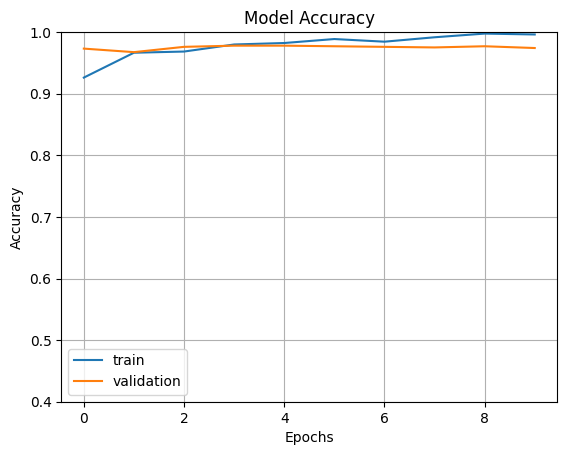

In [ ]:
fig = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

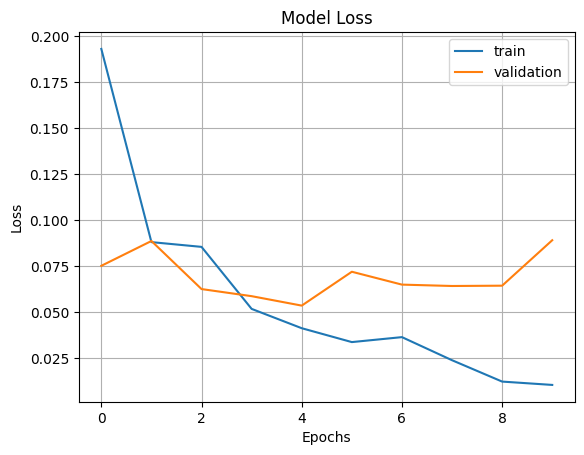

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

# Image Prediction

Upload a single image by unzipping the test zip
(which should already be in the folder saved in Desktop). Using OpenCV, predictions will be made.

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving IM-0001-0001.jpeg to IM-0001-0001.jpeg


In [ ]:
import cv2
img_path = "IM-0001-0001.jpeg" #name of single image. It will be in the Saving image to image once uploaded.

In [ ]:
image = cv2.imread(img_path)

In [ ]:
image_resized = cv2.resize(image, (224, 224))
image = np.expand_dims(image_resized, axis=0)
print(image.shape)

(1, 224, 224, 3)


In [ ]:
pred = convnext_model.predict(image)
print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.90421456 0.09578542]]


In [ ]:
output_class = class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is NORMAL


The prediction is correct. The model is 90 percent confident that the image given is normal lungs and no pneumonia